In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%matplotlib inline

### Leitura dos dados

In [18]:
dados = pd.read_csv("eleicoes_2006_a_2010.csv")
dados_teste = pd.read_csv("eleicoes_2014.csv")
dados_teste.columns = ["ano","sequencial_candidato","nome","uf","partido","quantidade_doacoes","quantidade_doadores","total_receita","media_receita","recursos_de_outros_candidatos/comites","recursos_de_pessoas_fisicas","recursos_de_pessoas_juridicas","recursos_proprios","quantidade_despesas","quantidade_fornecedores","total_despesa","media_despesa","cargo","sexo","grau","estado_civil","ocupacao","votos"]

### Preencher dados faltando e normalização

* O dados faltantes foram preenchido de modo que:
    * Os dados foram agrupados por partido, estado e ano e a mediana é atribuada. 
    * Aos dados que não tinham dados no primeiro grupo eram agrupados por partido e estado e atribuido a mediana desse grupo.
    * Persistindo, os dados eram agrupados por partido e a mediana do grupo é atribuida. 
    * Por último, para o restante dos dados são atribuidas as medianas da coluna.
* O dados numéricos que tinha um alto viés são transformados usando a função log1p. 

In [19]:
numeric_feats = dados.dtypes[dados.dtypes != "object"].index
#dados = dados.fillna(dados.mean())
dados[numeric_feats] = dados.groupby(['partido', 'uf', 'ano'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
dados[numeric_feats] = dados.groupby(['partido', 'uf'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
dados[numeric_feats] = dados.groupby(['partido'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

skewed_feats = dados[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
dados[skewed_feats] = np.log1p(dados[skewed_feats])

dados = dados.fillna(dados.median())

#Dados teste
numeric_feats_teste = dados_teste.dtypes[dados_teste.dtypes != "object"].index
#dados = dados.fillna(dados.mean())
dados_teste[numeric_feats_teste] = dados_teste.groupby(['partido', 'uf', 'ano'])[numeric_feats_teste].transform(lambda x: x.fillna(x.median()))
dados_teste[numeric_feats_teste] = dados_teste.groupby(['partido', 'uf'])[numeric_feats_teste].transform(lambda x: x.fillna(x.median()))
dados_teste[numeric_feats_teste] = dados_teste.groupby(['partido'])[numeric_feats_teste].transform(lambda x: x.fillna(x.median()))

skewed_feats_teste = dados_teste[numeric_feats_teste].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats_teste = skewed_feats_teste[skewed_feats_teste > 0.75]
skewed_feats_teste = skewed_feats_teste.index
dados_teste[skewed_feats_teste] = np.log1p(dados_teste[skewed_feats_teste])

dados_teste = dados_teste.fillna(dados_teste.median())

### Conversão de variáveis categóricas

* As variáveis categóricas foram transformadas usando One-Hot encoding.
* Foram removidas a variáveis nome e sequencial_candidato.

In [20]:
all_data = pd.concat((dados,dados_teste))
for column in all_data.select_dtypes(include=[np.object]).columns:
    dados[column] = dados[column].astype('category', categories = all_data[column].unique())
    dados_teste[column] = dados[column].astype('category', categories = all_data[column].unique())
dados = pd.get_dummies(dados, columns = ["uf","partido","cargo","sexo","grau","estado_civil","ocupacao"])
dados = dados.drop(columns = ['nome', 'sequencial_candidato'])
dados_teste = pd.get_dummies(dados_teste, columns = ["uf","partido","cargo","sexo","grau","estado_civil","ocupacao"])
dados_teste = dados_teste.drop(columns = ['nome', 'sequencial_candidato'])

C:\Users\Luiz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Luiz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  after removing the cwd from sys.path.


### Separação treino e teste

In [21]:
treino =  dados[dados.ano == 2006]
y_treino = treino.votos
treino = treino.drop(columns = ['votos'])

teste = dados[dados.ano == 2010]
y_teste = teste.votos
teste = teste.drop(columns = ['votos'])

In [22]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

### Função de cálculo de rmse com cross validation

In [23]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, treino, y_treino, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)


### Cálculo de rmse do ridge para diferentes alphas

In [24]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 7,8,9,10,11,12,13,15, 20,30,40,45, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

### Plot do RMSE para cada alpha

Text(0,0.5,'rmse')

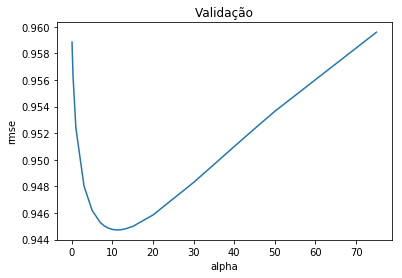

In [25]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validação")
plt.xlabel("alpha")
plt.ylabel("rmse")

### RMSE mínimo encontrado

In [26]:
cv_ridge.min()

0.9447270118637288

### Criação do modelo com melhor alpha

In [27]:
model_ridge = Ridge(alpha = cv_ridge.idxmin())
model_ridge.fit(treino, y_treino)

Ridge(alpha=11.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

### Coeficientes mais importantes do modelo Ridge

Text(0.5,1,'Coefficients in the Ridge Model')

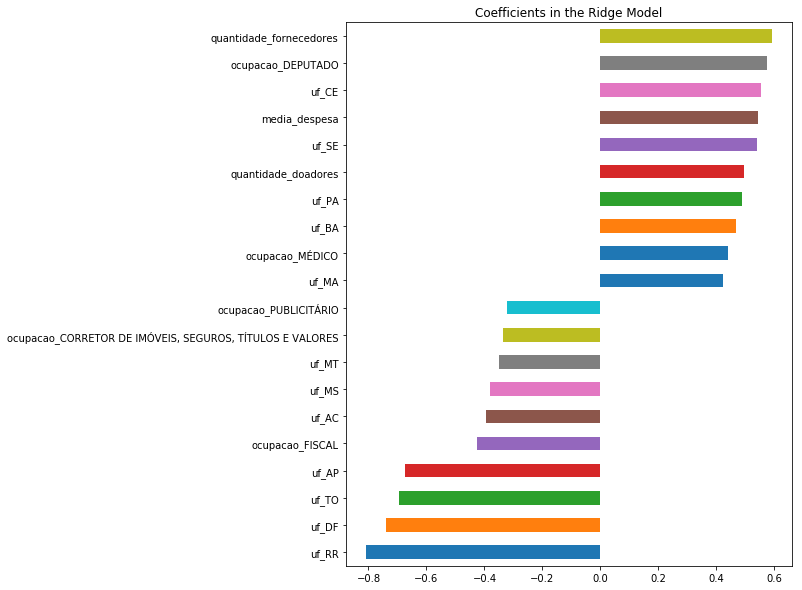

In [28]:
coef_ridge = pd.Series(model_ridge.coef_, index = treino.columns)
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10),
                     coef_ridge.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef_ridge.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

### Cálculo do R quadrado para o modelo criado

In [29]:
r_squared_ridge = model_ridge.score(teste, y_teste)
print(r_squared_ridge)

0.7097964793544047


### Gráfico de resíduos por predição

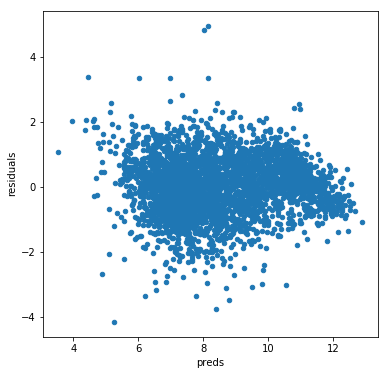

In [30]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_ridge.predict(treino), "true":y_treino})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Não é muito claro mas o gráfico de residuos aparenta ter uma pequena curvatura. Isso leva a crer que o não seja exatamente linear a relação entre os dados e o valor predito. 

### Função de cálculo de rmse com cross validation para o Lasso

In [31]:
alphas = [0.0001,0.005,0.0005,0.05, 0.1, 0.3]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=10000)).mean() 
            for alpha in alphas]

### Plot do RMSE para cada alpha

Text(0,0.5,'rmse')

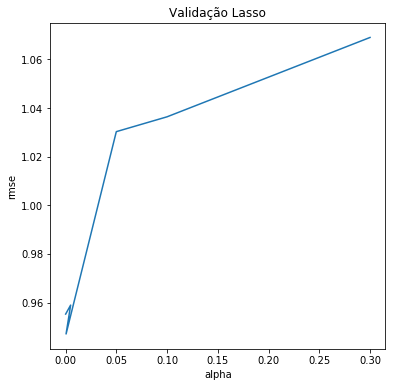

In [32]:
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validação Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

### RMSE mínimo encontrado

In [33]:
cv_lasso.min()

0.9470633139112566

### Criação do modelo com melhor alpha

In [34]:
model_lasso = Lasso(alpha = cv_lasso.idxmin(), max_iter=10000)
model_lasso.fit(treino, y_treino)
coef = pd.Series(model_lasso.coef_, index = treino.columns)
print("Lasso selecionou " + str(sum(coef != 0)) + " variáveis e eliminou outras " +  str(sum(coef == 0)) + " variáveis")

Lasso selecionou 130 variáveis e eliminou outras 153 variáveis


### Coeficientes mais importantes do modelo Lasso

Text(0.5,1,'Coefficients in the Lasso Model')

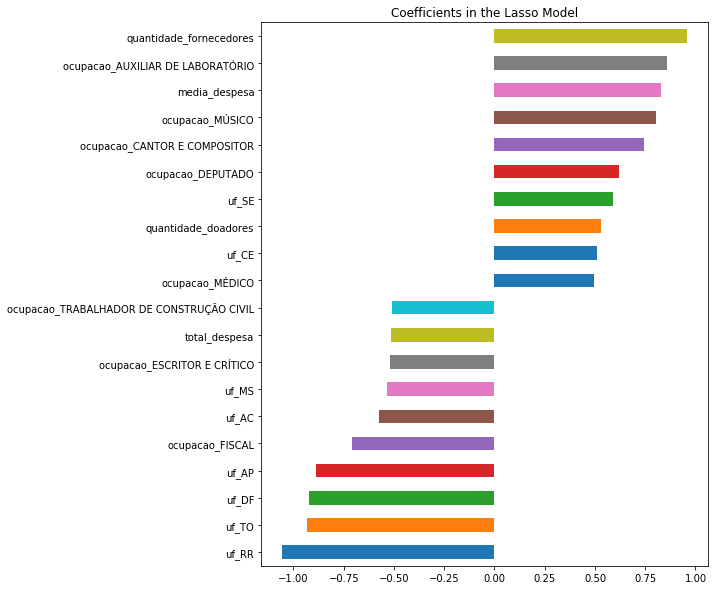

In [35]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Cálculo do R quadrado para o modelo criado

In [36]:
r_squared_lasso = model_lasso.score(teste, y_teste)
print(r_squared_lasso)

0.7091441230592921


### Gráfico de resíduos por predição

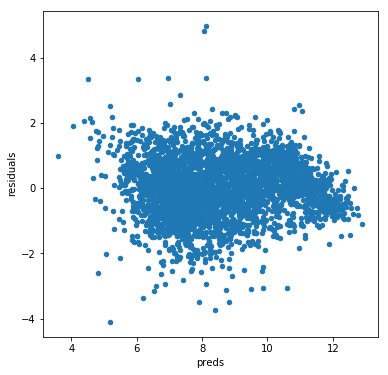

In [37]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(treino), "true":y_treino})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Assim como no Ridge, o gráfico de residuos aparenta ter uma pequena curvatura. Isso leva a crer que o não seja exatamente linear a relação entre os dados e o valor predito.

In [38]:
from sklearn.linear_model import LinearRegression

### Treino e teste para o modelo linear

Para rodar o método sem regularização modifiquei o treino e teste para usar apenas as colunas escolhidas pelo Lasso.

In [39]:
coef_linear = pd.Series(model_lasso.coef_, index = treino.columns)
treinoLinear = treino[treino.columns[coef != 0]]
testeLinear = teste[treino.columns[coef != 0]]

### Criação do modelo

In [40]:
reg = LinearRegression()
reg.fit(treinoLinear, y_treino)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Cálculo do R quadrado

In [41]:
reg.score(testeLinear, y_teste)

0.7072803845422084

### Plot de resíduos por predição

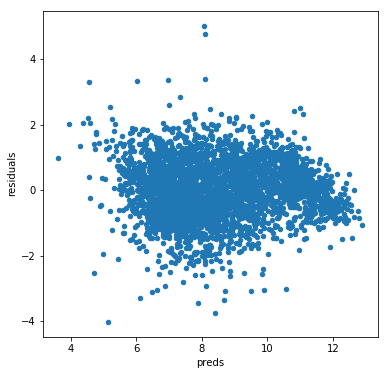

In [42]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":reg.predict(treinoLinear), "true":y_treino})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Assim como o Ridge e o Lasso, o gráfico de residuos aparenta ter uma pequena curvatura. Isso enforça a teoria que não seja exatamente linear a relação entre os dados e o valor predito.

### Função de cálculo de rmse com cross validation para o K-nn

In [43]:
from sklearn.neighbors import KNeighborsRegressor

In [44]:
alphas = [5,10,15,20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors=alpha)).mean() 
            for alpha in alphas]

### Plot do RMSE para cada número de vizinhos

Text(0,0.5,'rmse')

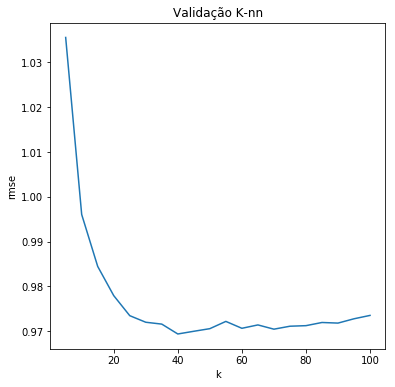

In [45]:
cv_knn = pd.Series(cv_knn, index = alphas)
cv_knn.plot(title = "Validação K-nn")
plt.xlabel("k")
plt.ylabel("rmse")

### RMSE mínimo encontrado

In [46]:
cv_knn.min()

0.9693717185026897

### Criação do modelo

In [47]:
neigh = KNeighborsRegressor(n_neighbors=cv_knn.idxmin())
neigh.fit(treino, y_treino) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=40, p=2,
          weights='uniform')

### Cálculo do R quadrado

In [48]:
neigh.score(teste, y_teste) 

0.7018403188455384

### Plot de resíduos por predição

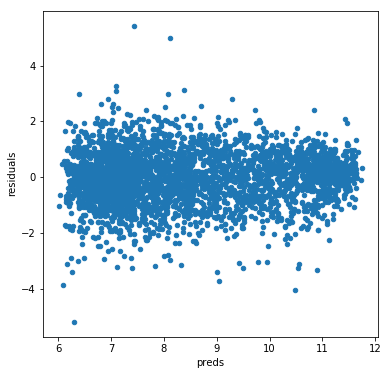

In [49]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":neigh.predict(treino), "true":y_treino})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Diferente dos modelos lineares os residuos aparentam estar distribuidos aleatóriamente em relação ao 0. Isso mostra que o modelo é adequado para o conjunto de dados.

### Função de cálculo de rmse com cross validation para o Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor

In [51]:
alphas = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
cv_random_forest = [rmse_cv(RandomForestRegressor(n_estimators=alpha)).mean() 
            for alpha in alphas]

### Plot do RMSE para cada número de árvores

Text(0,0.5,'rmse')

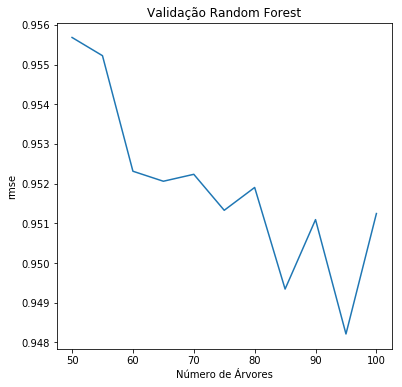

In [52]:
cv_random_forest = pd.Series(cv_random_forest, index = alphas)
cv_random_forest.plot(title = "Validação Random Forest")
plt.xlabel("Número de Árvores")
plt.ylabel("rmse")

### RMSE mínimo encontrado

In [53]:
cv_random_forest.min()

0.9482120581175462

In [54]:
forest = RandomForestRegressor(n_estimators=cv_random_forest.idxmin())
forest.fit(treino, y_treino) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Cálculo do R quadrado

In [55]:
forest.score(teste, y_teste) 

0.6986970746404276

### Plot de resíduos por predição

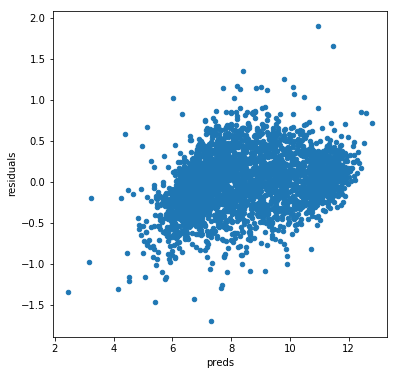

In [56]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":forest.predict(treino), "true":y_treino})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

O modelo aparenta tem uma tendencia crescente o que leva a questionar a validade do mesmo. Porém esse efeito parece ser pequeno.

### Leitura dos novos dados

In [57]:
from sklearn.metrics import mean_squared_error

### Criação dos modelos

In [60]:
y =  dados.votos
dados = dados.drop(columns = ['votos'])
y_2014 = dados_teste.votos
dados_teste = dados_teste.drop(columns = ['votos'])

In [58]:
def imprimirEstatisticas(nome, modelo):
    print(nome)
    predicao = modelo.predict(dados_teste)
    rmse = np.sqrt(mean_squared_error(y_2014, predicao))
    r_squared = modelo.score(dados_teste, y_2014)
    print("RMSE: ", rmse)
    print("R²: ", r_squared)

In [61]:
model_ridge = Ridge(alpha = cv_ridge.idxmin())
model_ridge.fit(dados, y)
imprimirEstatisticas("Ridge", model_ridge)
model_lasso = Lasso(alpha = cv_lasso.idxmin(), max_iter=10000)
model_lasso.fit(dados, y)
imprimirEstatisticas("Lasso", model_lasso)
reg = LinearRegression()
reg.fit(dados, y)
imprimirEstatisticas("Regressão Linear", reg)
neigh = KNeighborsRegressor(n_neighbors=cv_knn.idxmin())
neigh.fit(dados, y)
imprimirEstatisticas("K-nn", neigh)
forest = RandomForestRegressor(n_estimators=cv_random_forest.idxmin())
forest.fit(dados, y)
imprimirEstatisticas("Random Forest", forest)

Ridge
RMSE:  1.83947161957029
R²:  0.4820552806206254
Lasso
RMSE:  1.8392693337060046
R²:  0.48216919065129193
Regressão Linear
RMSE:  1.8531774725088563
R²:  0.47430814189088966
K-nn
RMSE:  1.8465831346197923
R²:  0.4780427242943903
Random Forest
RMSE:  1.8830857808162569
R²:  0.45720300540876757


### Conclusão
Mesmo o K-nn dando a entender que poderia prever melhor dado os resíduos o Ridge e o Lasso foram os algortimos que tiveram os melhores resultados tanto no RMSE como no R². Isso se deve ao fato que a regularização ajuda a evitar o overfit e ter resultados melhores prevendo dados nunca vistos. 